In [9]:
%load_ext autoreload
%autoreload 1
%aimport Utils
%aimport MatrixLinkGenerator
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
# np.set_printoptions(linewidth=np.inf)
from obspy import UTCDateTime
import json
import matplotlib.pyplot as plt
from Utils import trainingResults, trainingResults2, predsMap
# plt.rcParams['figure.figsize'] = [50, 200]
plt.rcParams['figure.figsize'] = [16, 12]
params = json.loads('''{
    "extents": {
        "s1": {
            "latMin": 22.0,
            "latMax": 40.0,
            "lonMin": 33.0,
            "lonMax": 62.0
        }
    },
    "location": "s1",
    "maxDepth": 50.0,
    "maxStationElevation": 0.5,
    "trainingGeneratorSourceFile": "./Training/Inputs/S1 00.gz",
    "trainingEventsFile": "./Training/Event Files/S1 Events 22-40-33-62 3+ Arrivals 120 TimeNorm.npz",
    "validationGeneratorSourceFile": "./Inputs/S1 00.gz",
    "validationEventsFile": "./Training/Event Files/S1 Events 22-40-33-62 3+ Arrivals 120 TimeNorm.npz",
    "arrivalProbsFile": "./Training/RSTT Model/S1 Dropouts.npy",
    "stationFile": "./Archive/Stations/S1 Station List.txt",
    "arrivalProbMods": {
        "Pg": 7.0,
        "Pn": 4.5,
        "Sg": 7.0,
        "Sn": 25.0
    },
    "eventsPerExample": {
        "min": 1,
        "max": 4
    },
    "stationsPerBatch": {
        "min": 45,
        "max": 55
    },
    "timeShifts": {
        "min": -0.50,
        "max": 0.50
    },
    "batchSize": 1000,
    "samplesPerEpoch": 1000000,
    "validationSamplesPerEpoch": 250000,
    "epochs": 400,
    "model": "./Training/Models/E399 L0.0264 AL0.0021 NL0.0029 LL0.0023 AP0.9265 AR0.9142 NP0.7401 NR0.8000 HL95.6.h5",
    "evalInFile": "./Inputs/S1 00.gz",
    "evalOutFile": "./Training/Evaluation.gz",
    "prlEvalOutFile": "./Training/PRL Evaluation.gz",
    "maxArrivals": 50,
    "minArrivals": 5,
    "maxNoise": 0.20,
    "clusterStrength": 0.9,
    "timeNormalize": 120,
    "associationWindow": 300,
    "evalWindow": 10.0,
    "phases": {
        "Pg": 0, "PcP": 0, "Pb": 0,
        "P": 1, "Pn": 1,
        "S": 2, "Sg": 2, "ScP": 2, "Lg": 2, "Sb": 2,
        "Sn": 3
    },
    "modelArch": {
        "dense": [32, 32, 64, 128, 128],
        "transformers": [256, 256],
        "heads": 4,
        "dense2": [128, 128, 128],
        "grus": [256, 256]
    }
}''')
tf.config.list_physical_devices()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#MatrixLinkTrainer
import tensorflow as tf
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Embedding, Reshape, concatenate, Dense, Bidirectional, GRU, MultiHeadAttention, LayerNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import logging
import json
from MatrixLinkGenerator import generateEventFile, synthesizeEvents, synthesizeEventsFromEventFile
from Utils import nzBCE, nzMSE, nzPrecision, nzRecall, nzHaversine, trainingResults

@tf.autograph.experimental.do_not_convert
def MatrixLink(params):
    logging.getLogger("tensorflow").setLevel(logging.ERROR)
    def buildModel(modelArch):
        outputs = []
        inputs = []
        numericalInputs = Input(shape=(None,4), name='numerical_features')
        outputs.append(numericalInputs)
        inputs.append(numericalInputs)
        categoricalInputs = Input(shape=(None,1), name='phase')
        embed = Embedding(5, 2, trainable=True, embeddings_initializer=RandomNormal())(categoricalInputs)
        embed = Reshape(target_shape=(-1,2))(embed)
        outputs.append(embed)
        inputs.append(categoricalInputs)
        outputs = concatenate(outputs)

        def TransformerBlock(inputs, embed_dim, ff_dim, num_heads=2, rate=0.1, eps=1e-6):
            attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
#             attn_output = Dropout(rate)(attn_output)
            out1 = LayerNormalization(epsilon=eps)(inputs + attn_output)
            ffn_output = Dense(ff_dim, activation="relu")(out1)
            ffn_output = Dense(embed_dim)(ffn_output)
#             ffn_output = Dropout(rate)(ffn_output)
            return LayerNormalization(epsilon=eps)(out1 + ffn_output) 

        for d1Units in modelArch['dense']:
            outputs = Dense(units=d1Units, activation=tf.nn.relu)(outputs)
        transformerOutputs = outputs
        gruOutputs = outputs

        for tUnits in modelArch['transformers']:
            transformerOutputs = TransformerBlock(transformerOutputs, d1Units, tUnits, modelArch['heads'])
        for gUnits in modelArch['grus']:
            gruOutputs = Bidirectional(GRU(gUnits, return_sequences=True))(gruOutputs)

        outputs = concatenate([transformerOutputs, gruOutputs], axis=2)
        for tUnits in modelArch['transformers']:
            outputs = TransformerBlock(outputs, d1Units+gUnits*2, tUnits, modelArch['heads'])

        association = Dense(units=params['maxArrivals'], activation=tf.nn.sigmoid, name='association')(outputs)
        location = Dense(units=2, name='location')(outputs)
        noise = Dense(units=1, activation=tf.nn.sigmoid, name='noise')(outputs)
        
        model = Model(inputs=inputs, outputs=[association, location, noise])
        losses = { 'association': nzBCE, 'location': nzMSE, 'noise': nzBCE }
        weights = { 'association': 1.0, 'location': 10.0, 'noise': 0.5 }
        metrics = { 'association': [nzPrecision, nzRecall],
                    'location': nzHaversine,
                    'noise': [nzPrecision, nzRecall]
                  }
        model.compile(optimizer=Adam(clipnorm=0.00001), loss=losses, loss_weights=weights, metrics=metrics)
        return model

    model = buildModel(params['modelArch'])
    try:
        model.load_weights(params['model'])
        print("Loaded previous weights.")
    except Exception as e:
        print(e)
        print("No previous weights loaded.")
    print(model.summary())
    return model

class saveCb(Callback):
    def on_train_begin(self, logs=None):
        self.best = 100.
    def on_epoch_end(self, epoch, logs=None):
        if logs['loss'] < self.best:
            self.best = logs['loss']
            print('Saving best model with loss', self.best)
#             modelName = 'E%03d L%.4f A%.4f P%.4f R%.4f HL%.1f VL%.4f VA%.4f VP%.4f VR%.4f VHL%.1f.h5' %\
#                 (epoch, logs['loss'], logs['association_nzAccuracy'], logs['association_precision'], logs['association_recall'], logs['location_nzHaversine'], 
#                  logs['val_loss'], logs['val_association_nzAccuracy'], logs['val_association_precision'], logs['val_association_recall'], logs['val_location_nzHaversine'])
            modelName = 'E%03d L%.4f AL%.4f NL%.4f LL%.4f AP%.4f AR%.4f NP%.4f NR%.4f HL%.1f.h5' %\
                (epoch, logs['loss'], logs['association_loss'], logs['noise_loss'], logs['location_loss'], logs['association_nzPrecision'], logs['association_nzRecall'], logs['noise_nzPrecision'], logs['noise_nzRecall'], logs['location_nzHaversine'])
            model.save("./Training/Models/"+modelName)

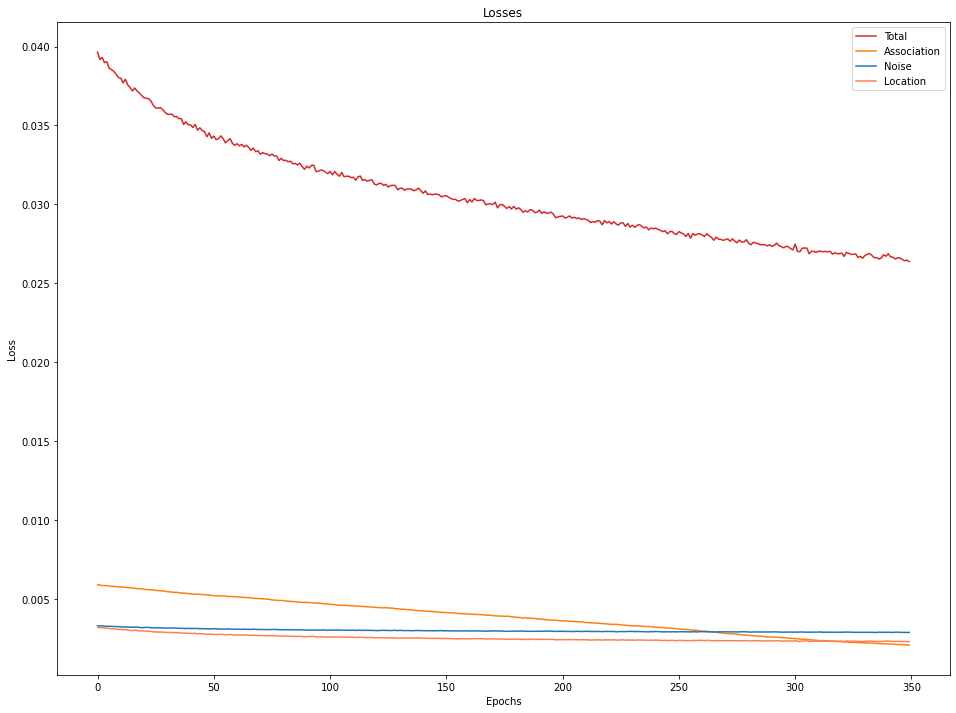

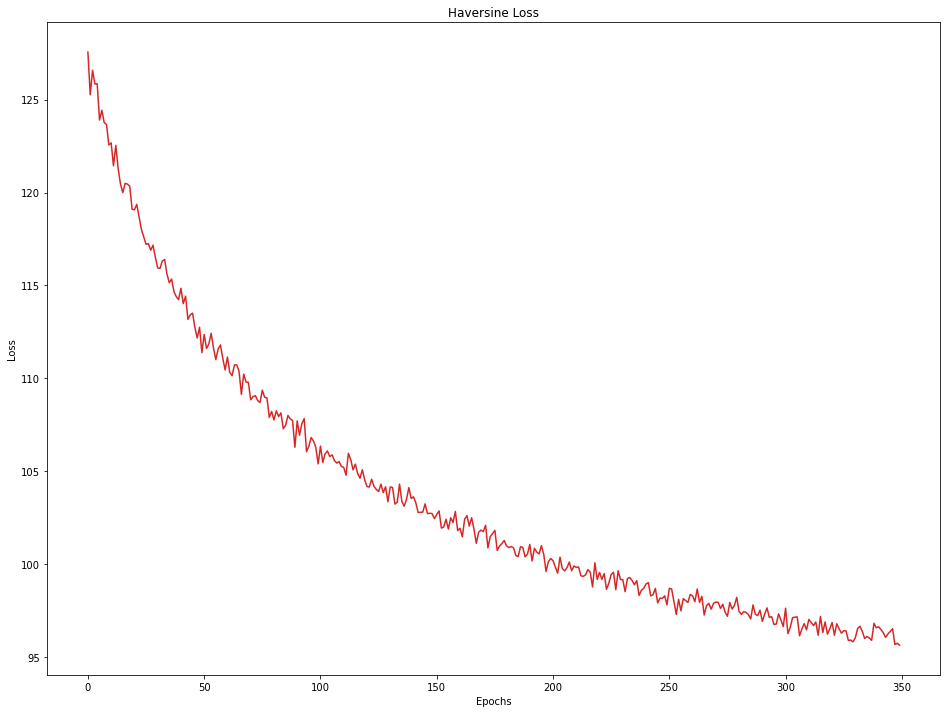

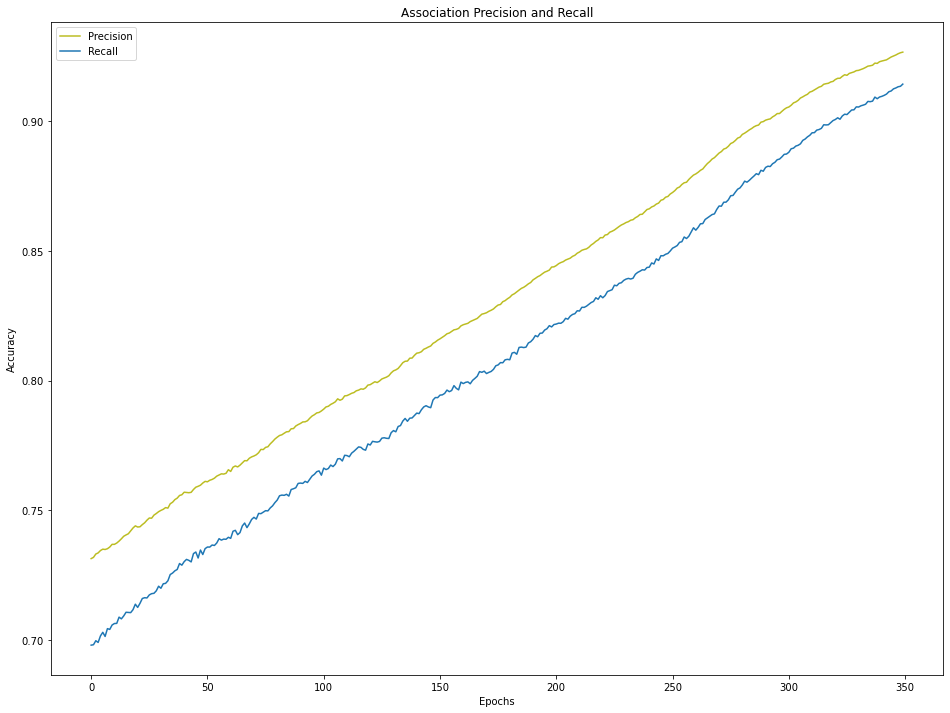

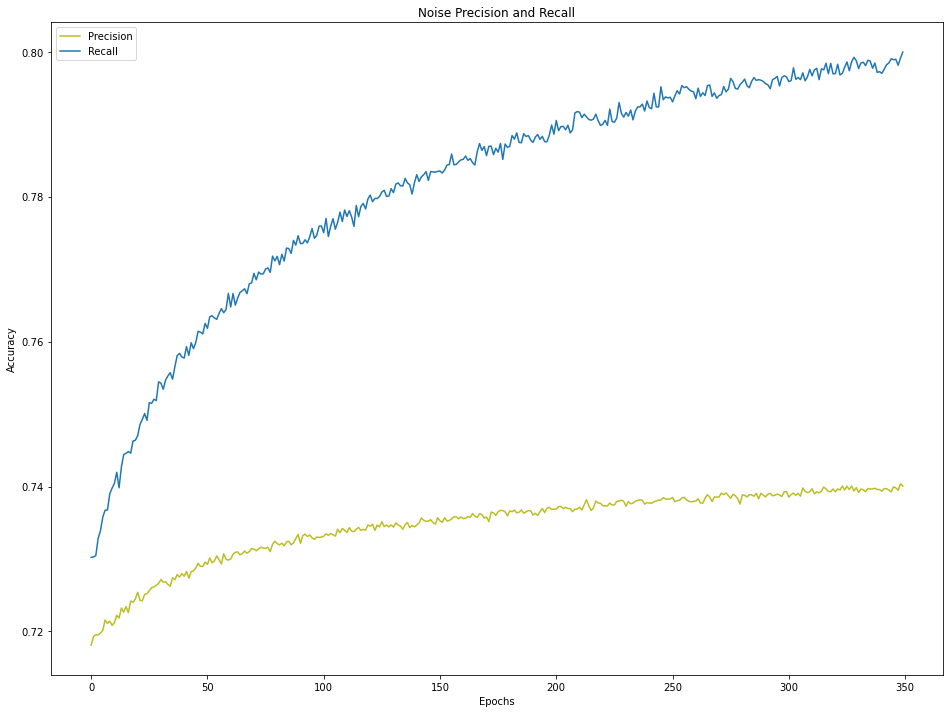

<Figure size 1152x864 with 0 Axes>

In [8]:
# tf.config.threading.set_intra_op_parallelism_threads(2)
# tf.config.threading.set_inter_op_parallelism_threads(2)

# trainingEvents, trainingEventList = generateEventFile(params, trainingSet=True)
# validationEvents, validationEventList = generateEventFile(params)

# generator = synthesizeEventsFromEventFile(params, trainingEvents, trainingEventList, trainingSet=True)
generator = synthesizeEvents(params)
# vgen = synthesizeEventsFromEventFile(params, validationEvents, validationEventList)
# vgen = synthesizeEvents(params)

model = MatrixLink(params)
history = model.fit(generator,
#                  validation_data=vgen,
                 steps_per_epoch= params['samplesPerEpoch']/params['batchSize'],
#                  validation_steps = params['validationSamplesPerEpoch']/params['batchSize'],
                 epochs=params['epochs'],
                 callbacks=[saveCb(), EarlyStopping(monitor='loss', patience=40), CSVLogger('./Training/Models/logs.csv', append = True)],
                 verbose=1)
trainingResults2(np.genfromtxt('./Training/Models/logs.csv', delimiter=',', names=True)[50:])

In [ ]:
#MatrixLink
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from collections import deque
from math import ceil
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
from tensorflow.keras.models import load_model
from obspy import UTCDateTime
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import squareform
from Utils import nzBCE, nzBCE2, nzMSE, nzMSE2, nzHaversine, nzAccuracy, nzPrecision, nzRecall, evaluate

# Build permutation lists and matrices to predict on
def permute(X):
    outerWindow = params['associationWindow']
    minArrivals = params['minArrivals']
    maxArrivals = params['maxArrivals']
    edgeWindow = outerWindow/5
    numWindows = ceil((X[:,2].max() + edgeWindow*2) / edgeWindow)
    innerWindows = deque()
    X_perm = deque()
    start = -edgeWindow
    for window in range(numWindows):
        print('\rCreating permutations... ' + str(window) + ' / ' + str(numWindows), end='')
        end = start+outerWindow
        windowArrivals = np.where((X[:,2] >= start) & (X[:,2] < end))[0]
        start += edgeWindow
        if len(windowArrivals) >= minArrivals:
            X_perm.append(windowArrivals[:maxArrivals])
            innerWindows.append(start)
            
            #Experimental
#             if len(windowArrivals) > maxArrivals:
#                 print(len(windowArrivals), end=' ')
#                 extras = len(windowArrivals) - maxArrivals
#                 for s in [s+1 for s in range(extras)]:
#                     X_perm.append(windowArrivals[s:s+maxArrivals])
#                     innerWindows.append(start)

    X_test = np.zeros((len(X_perm),maxArrivals,5))
    for i in range(len(X_perm)):
        X_test[i,:len(X_perm[i])] = X[X_perm[i]]
        X_test[i,:len(X_perm[i]),2] -= X_test[i,0,2]
    X_test[:,:,2] /= params['timeNormalize']
    return X_perm, X_test, innerWindows

def buildEvents(X, labels, X_perm, X_test, Y_pred, innerWindows):
    # Get clusters for predicted matrix at index i
    def cluster(i):
        valids = np.where(X_test[i][:,4])[0]
        validPreds = Y_pred[0][i][valids,:len(valids)]
        L = 1-((validPreds.T + validPreds)/2)
        np.fill_diagonal(L,0)
        return fcluster(ward(squareform(L)), params['clusterStrength'], criterion='distance')

    innerWindow = params['associationWindow'] * (3/5)
    minArrivals = params['minArrivals']
    timeNormalize = params['timeNormalize']
    catalogue = pd.DataFrame(columns=labels.columns)
#     events = deque()
    evid = 1
    created = 1
    for window in range(len(X_perm)):
        clusters = cluster(window)
        for c in np.unique(clusters):
            pseudoEventIdx = np.where(clusters == c)[0]
            pseudoEvent = X_perm[window][pseudoEventIdx]
            if len(pseudoEvent) >= minArrivals:
                event = X[pseudoEvent]
                # check for containment within inner window
                contained = (event[0,2] >= innerWindows[window]) & (event[-1,2] <= (innerWindows[window]+innerWindow))
                if contained:
                    candidate = labels.iloc[pseudoEvent].copy()
                    candidate['PLAT'] = Y_pred[1][window][pseudoEventIdx][:,0]*latRange+extents[0]
                    candidate['PLON'] = Y_pred[1][window][pseudoEventIdx][:,1]*lonRange+extents[2]
#                     candidate['LAT'] = np.median(Y_pred[2][window][pseudoEventIdx][:,0])*latRange+extents[0]
#                     candidate['LON'] = np.median(Y_pred[2][window][pseudoEventIdx][:,1])*lonRange+extents[2]
                    candidate['LAT'] = np.median(candidate.PLAT)
                    candidate['LON'] = np.median(candidate.PLON)
                    # check for existence in catalogue
                    overlap = candidate.ARID.isin(catalogue.ARID).sum()
                    if overlap == 0:
                        print("\rPromoting event " + str(created), end='')
#                         events.append(pseudoEvent)
                        candidate.EVID = evid
                        catalogue = catalogue.append(candidate)
                        evid += 1
                        created += 1
                    elif len(pseudoEvent) > overlap:
                        catalogue.drop(catalogue[catalogue.ARID.isin(candidate.ARID)].index, inplace=True)
                        candidate.EVID = evid
                        catalogue = catalogue.append(candidate)
                        evid += 1
    catalogue = catalogue.groupby('EVID').filter(lambda x: len(x) >= minArrivals)
    print()
    return catalogue

def matrixLink(X, labels):
    X_perm, X_test, innerWindows = permute(X)
    print("\nMaking initial predictions... ", end='')
    Y_pred = model.predict({"phase": X_test[:,:,3], "numerical_features": X_test[:,:,[0,1,2,4]]})
#     print("eliminating noise and predicting again... ", end='')
#     for _ in range(3):
#         valids = deque()
#         for i in range(len(X_perm)):
#             valid = np.where(Y_pred[2][i] < 0.008)[0]
#             valids.append(X_perm[i][valid[valid < len(X_perm[i])]])
#         valids = np.array(list(set(np.concatenate(valids))))
#         X = X[valids]
#         labels = labels.iloc[valids]
#         X_perm, X_test, innerWindows = permute(X)
#         Y_pred = model.predict({"phase": X_test[:,:,3], "numerical_features": X_test[:,:,[0,1,2,4]]})
    print("clustering and building events...")
    catalogue = buildEvents(X, labels, X_perm, X_test, Y_pred, innerWindows)
    return catalogue

def processInput():
    print("Reading input file... ", end='')
    X = []
    labels = []
    for i, r in inputs.iterrows(): # I can do this better
        phase = r.PHASE
        time = UTCDateTime(r.TIME)
        lat = abs((r.ST_LAT - extents[0]) / latRange)
        lon = abs((r.ST_LON - extents[2]) / lonRange)
        otime = time - UTCDateTime(0)
        try:
            arrival = [lat, lon, otime, phases[phase], 1]
            X.append(arrival)
            labels.append(r)
        except Exception as e:
            print(e)
    X = np.array(X)
    idx = np.argsort(X[:,2])
    X = X[idx,:]
    X[:,2] -= X[0,2]
    labels = pd.DataFrame([labels[i] for i in idx])
    print("%d arrivals found" % len(labels))
    return X, labels

if __name__ == "__main__":
    pd.options.display.float_format = "{:.2f}".format
#     with open("Parameters.json", "r") as f:
#         params = json.load(f)
    phases = params['phases']
    extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
    latRange = abs(extents[1] - extents[0])
    lonRange = abs(extents[3] - extents[2])
    model = load_model(params['model'], custom_objects={'nzBCE':nzBCE, 'nzBCE2':nzBCE2, 'nzMSE':nzMSE, 'nzMSE2':nzMSE2, 'nzHaversine':nzHaversine, 'nzPrecision':nzPrecision, 'nzRecall':nzRecall, 'nzAccuracy':nzAccuracy}, compile=True)

#     inFiles = ['./Inputs/S1 50.gz', './Inputs/S1 25.gz', './Inputs/S1 15.gz', './Inputs/S1 00.gz']
    inFiles = ['./Inputs/S1 00.gz']
    evals = {file:[] for file in inFiles}
    for i in range(len(inFiles)):
        inputs = pd.read_pickle(inFiles[i]).sort_values(by=['TIME']).reset_index(drop=True)
        params['evalInFile'] = inFiles[i]
#         start = inputs[inputs.TIME >= inputs.TIME.quantile(.8)].index[0]
#         end = inputs[inputs.TIME >= inputs.TIME.quantile(.825)].index[0]
#         inputs = inputs[start:end]

        X, labels = processInput()
        outputs = matrixLink(X, labels)
        outputs.to_pickle(params['evalOutFile'])
        evals[inFiles[i]] = evaluate(params, inputs, outputs, verbose=False)

    print("Consolidated summary for:", params['model'])
    print('File\tAHM\t Location')
    for file in evals.keys():
        print(file[-5:-3], "{:8.2f}".format(evals[file][0]), "{:8.2f}".format(evals[file][1]))

Reading input file... 204550 arrivals found
Creating permutations... 892216 / 912277

In [107]:
#Testing stuff
# extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
# latRange = abs(extents[1] - extents[0])
# lonRange = abs(extents[3] - extents[2])
synth = synthesizeEvents(params)
test = next(synth)
# total = params['batchSize']*params['maxArrivals']*params['maxArrivals']
# padding = np.sum(test[0]['numerical_features'][:,:,3]==0)*params['maxArrivals']
# positiveProp = np.sum(test[1]==1) / (total-padding)
# y = np.bincount(test[0]['phase'].flatten().astype(int))
# y[0] -= padding/params['maxArrivals']
# ii = np.nonzero(y)
# phaseProportions = np.vstack((ii,y[ii]/((total-padding)/params['maxArrivals']))).T
# print("Total:",total)
# print("Padding:",padding,padding/total)
# print("Ones:",np.sum(test[1]==1),positiveProp)
# print("Phases:\n",phaseProportions)

# validationEvents, validationEventList = generateEventFile(params, trainingSet=False)
# synthEvents = synthesizeEventsFromEventFile(params,validationEvents,validationEventList,False)
# test = next(synthEvents)

# model = load_model(params['model'], custom_objects={'nzBCE':nzBCE, 'nzMSE':nzMSE, 'nzHaversine':nzHaversine, 'nzPrecision':nzPrecision, 'nzRecall':nzRecall})
# preds = model.predict(test[0])
# preds[1][:,:,0] = preds[1][:,:,0]*latRange + extents[0]
# preds[1][:,:,1] = preds[1][:,:,1]*lonRange + extents[2]
# test[1]['location'][:,:,0] = test[1]['location'][:,:,0]*latRange + extents[0]
# test[1]['location'][:,:,1] = test[1]['location'][:,:,1]*lonRange + extents[2]

# def cluster(data, i):
#     valids = np.where(test[0]['numerical_features'][i][:,3])[0]
#     validPreds = data[i][valids,:len(valids)]
#     L = 1-((validPreds.T + validPreds)/2)
#     np.fill_diagonal(L,0)
#     return fcluster(ward(squareform(L)), params['clusterStrength'], criterion='distance')

# i=0
# valids=np.where(test[0]['numerical_features'][i][:,3])
# numValid=len(valids[0])
# print("Arrivals:")
# print(test[0]['numerical_features'][i][valids])
# print("Predicted clusters:")
# print(cluster(preds[0], i))
# # print("Actual matrix:")
# # print(test[1]['association'][i][:numValid,:numValid])
# print("Actual clusters:")
# print(cluster(test[1]['association'], i))
# print("Predicted locations/times:")
# print(np.hstack([preds[1][i][:numValid], preds[2][i][:numValid]]))
# print("Actual locations/times:")
# print(np.hstack([test[1]['location'][i][:numValid], np.expand_dims(test[1]['time'][i][:numValid],axis=1)]))
# print("Mean time error:", np.mean(abs(preds[2][i][:numValid]-test[1]['time'][i][:numValid])))

# locations = []
# for ex in range(params['batchSize']):
#     realClusters = cluster(test[1]['association'], ex)
#     evids, counts = np.unique(realClusters, return_counts=True)
#     evids = evids[np.where(counts >= params['minArrivals'])]
#     for evid in range(len(evids)):
#         latlons = test[1]['location'][ex][np.where(realClusters == evids[evid])]
#         realLat, realLon = np.median(latlons[:,0]), np.median(latlons[:,1])
#         latlons = preds[1][ex][np.where(realClusters == evids[evid])]
#         predLat, predLon = np.median(latlons[:,0]), np.median(latlons[:,1])
#         locations.append([realLat, realLon, predLat, predLon])
# locations = np.array(locations)
# stations = test[0]['numerical_features'][:,:,[0,1]].reshape(-1,2)
# stations = np.unique(stations, axis=0)
# stations[:,0] = stations[:,0]*latRange + extents[0]
# stations[:,1] = stations[:,1]*lonRange + extents[2]

# print(test[1]['association'][i])
# print(np.round(preds[0][i]))
# print(test[1]['noise'][i])
# print(np.round(preds[2][i].T))
# from tensorflow.keras import backend as K


[[0.784 0.513 -3.5 36.1 47.9 1.75]
 [0.687 0.608 -3.95 34.4 50.6 1.97]
 [0.614 0.99 -1.7 33.1 61.7 0.85]
 [0.564 0.692 -5.04 32.2 53.1 2.52]
 [0.494 0.783 -3.5 30.9 55.7 1.75]
 [0.987 0.609 -0.184 39.8 50.7 0.0918]
 [0.731 0.663 -5.09 35.2 52.2 2.55]
 [0.783 0.722 -3.81 36.1 53.9 1.9]
 [0.705 0.45 -3.97 34.7 46 1.98]
 [0.633 0.673 -4.59 33.4 52.5 2.3]
 [0.34 0.843 -3.22 28.1 57.5 1.61]
 [0.524 0.611 -0.349 31.4 50.7 0.175]
 [0.693 0.531 -5.03 34.5 48.4 2.51]
 [0.631 0.602 -4.45 33.4 50.4 2.22]
 [0.944 0.378 -4.68 39 44 2.34]
 [0.747 0.533 -3.67 35.4 48.4 1.84]
 [0.294 0.71 -1.58 27.3 53.6 0.791]
 [0.0525 0.868 -0.012 22.9 58.2 0.00599]
 [0.763 0.647 -4.02 35.7 51.8 2.01]
 [0.846 0.558 -4.24 37.2 49.2 2.12]
 [0.784 0.694 -5.19 36.1 53.1 2.59]
 [0.749 0.629 -2.27 35.5 51.2 1.13]
 [0.74 0.595 -2.85 35.3 50.3 1.42]
 [0.664 0.555 -3.34 34 49.1 1.67]
 [0.73 0.597 -2.04 35.1 50.3 1.02]
 [0.39 0.726 -2.05 29 54 1.02]
 [0.896 0.534 -4.28 38.1 48.5 2.14]
 [0.78 0.659 -4.66 36 52.1 2.33]
 [0.271 